# Panel IV Skew Quintile Regressions

This notebook scales the single-firm quintile FF3 regressions to a panel of firms. We:

1. Load the merged dataset from `data_loader.ipynb`.
2. Pick the top 50 tickers by available weekly observations.
3. Within each ticker, form IV skew quintiles and run FF3 (with HC1 SEs) per quintile.
4. Aggregate results to see which quintiles show the most significant alphas across firms.

Feel free to tweak the universe size, minimum observations, or regression settings.


In [24]:
import pandas as pd
import polars as pl
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.max_columns", None)
print("✓ Libraries ready")


✓ Libraries ready


In [25]:
DATA_DIR = Path("processed_data")
MERGED_PATH = DATA_DIR / "merged_data_with_ff3.parquet"
TOP_N_TICKERS = 50  # Only used when sampling by size
MIN_OBS_PER_QUINTILE = 20
USE_BIG_TICKERS = False
USE_ALL_TICKERS = True

BIG_TICKERS = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA", "BRK.B",
    "JPM", "V", "MA", "JNJ", "UNH", "PG", "HD", "PEP", "XOM", "CVX",
    "LLY", "MRK", "KO", "CSCO", "INTC", "AVGO", "ABT", "MCD", "WMT",
    "BAC", "ADBE", "CRM", "NFLX", "NKE", "TMO", "AMD", "ORCL", "COST",
    "DIS", "TXN", "AMAT", "QCOM", "LIN", "PM", "BMY", "IBM", "HON",
    "GE", "SBUX", "CAT", "GS"
]

print(f"Loading dataset from {MERGED_PATH} ...")
merged_df = pl.read_parquet(MERGED_PATH)
print(f"✓ Loaded shape: {merged_df.shape}")


Loading dataset from processed_data/merged_data_with_ff3.parquet ...
✓ Loaded shape: (514768, 17)


In [26]:
REQUIRED_COLS = [
    "secid", "TICKER", "week_start", "week_end",
    "IV_skew", "weekly_return", "Mkt-RF", "SMB", "HML", "RF"
]

clean_pl = (
    merged_df
    .select(REQUIRED_COLS)
    .drop_nulls(["IV_skew", "weekly_return", "Mkt-RF", "SMB", "HML", "RF"])
)

if USE_BIG_TICKERS:
    existing_big = (
        clean_pl
        .filter(pl.col("TICKER").is_in(BIG_TICKERS))
        .group_by("TICKER")
        .agg(pl.len().alias("n_obs"))
        .sort("TICKER")
        .to_pandas()
    )
    missing = sorted(set(BIG_TICKERS) - set(existing_big["TICKER"]))
    if missing:
        print(f"Tickers missing from dataset (skipped): {missing}")
    universe_df = existing_big
    print(f"Using {len(universe_df)} big-name tickers found in data")
elif USE_ALL_TICKERS:
    universe_df = (
        clean_pl
        .group_by("TICKER")
        .agg(pl.len().alias("n_obs"))
        .sort("TICKER")
        .to_pandas()
    )
    print(f"Using all {len(universe_df)} tickers with sufficient data")
else:
    universe_df = (
        clean_pl
        .group_by("TICKER")
        .agg(pl.len().alias("n_obs"))
        .sort("n_obs", descending=True)
        .head(TOP_N_TICKERS)
        .to_pandas()
    )
    print(f"Top {TOP_N_TICKERS} tickers by usable observations:")

universe_df.head(10)


Using all 4217 tickers with sufficient data


,TICKER,n_obs
0,A,244
1,AA,244
2,AABA,37
3,AAC,8
4,AACQ,18
5,AADI,37
6,AAIC,2
7,AAL,244
8,AAN,225
9,AAOI,203


In [27]:
universe_df

,TICKER,n_obs
0,A,244
1,AA,244
2,AABA,37
3,AAC,8
4,AACQ,18
...,...,...
4212,ZWS,64
4213,ZY,41
4214,ZYME,179
4215,ZYNE,60


In [28]:
def star_from_p(pval: float) -> str:
    if np.isnan(pval):
        return ""
    if pval < 0.01:
        return "***"
    if pval < 0.05:
        return "**"
    if pval < 0.10:
        return "*"
    return ""


def run_ff3(subset: pd.DataFrame) -> sm.regression.linear_model.RegressionResultsWrapper:
    X = subset[["Mkt-RF", "SMB", "HML"]]
    X = sm.add_constant(X)
    y = subset["excess_return"]
    ols_res = sm.OLS(y, X).fit()
    robust = ols_res.get_robustcov_results(cov_type="HC1")
    robust.rsq = ols_res.rsquared
    return robust


def prep_ticker_frame(ticker: str) -> pd.DataFrame:
    ticker_pl = (
        clean_pl
        .filter(pl.col("TICKER") == ticker)
        .with_columns((pl.col("weekly_return") - pl.col("RF")).alias("excess_return"))
        .sort("week_start")
    )
    if ticker_pl.height == 0:
        return pd.DataFrame()
    df = ticker_pl.to_pandas()
    df["week_start"] = pd.to_datetime(df["week_start"])
    df["week_end"] = pd.to_datetime(df["week_end"])
    df["iv_quintile"] = (
        pd.qcut(df["IV_skew"], q=5, labels=False, duplicates="drop")
        .astype("float")
        .add(1)
    )
    return df


In [29]:
def compute_quintile_results(df: pd.DataFrame, ticker: str) -> list[dict]:
    rows = []
    if df.empty:
        return rows
    for quint in sorted(df["iv_quintile"].dropna().unique()):
        bucket = df[df["iv_quintile"] == quint]
        if len(bucket) < MIN_OBS_PER_QUINTILE:
            continue
        model = run_ff3(bucket)
        params = pd.Series(model.params, index=model.model.exog_names)
        tvals = pd.Series(model.tvalues, index=model.model.exog_names)
        pvals = pd.Series(model.pvalues, index=model.model.exog_names)
        rows.append({
            "ticker": ticker,
            "quintile": int(quint),
            "n_obs": len(bucket),
            "alpha": params["const"],
            "alpha_t": tvals["const"],
            "alpha_p": pvals["const"],
            "alpha_sig": star_from_p(pvals["const"]),
            "beta_mkt": params["Mkt-RF"],
            "beta_mkt_t": tvals["Mkt-RF"],
            "beta_mkt_p": pvals["Mkt-RF"],
            "beta_smb": params["SMB"],
            "beta_smb_t": tvals["SMB"],
            "beta_smb_p": pvals["SMB"],
            "beta_hml": params["HML"],
            "beta_hml_t": tvals["HML"],
            "beta_hml_p": pvals["HML"],
            "r_squared": getattr(model, "rsq", np.nan)
        })
    return rows


In [30]:
panel_rows = []
for ticker in universe_df["TICKER"]:
    firm_df = prep_ticker_frame(ticker)
    if firm_df.empty:
        print(f"{ticker}: no usable data (skipped)")
        continue
    rows = compute_quintile_results(firm_df, ticker)
    panel_rows.extend(rows)
    print(f"{ticker}: {len(rows)} quintile regressions")

panel_results = pd.DataFrame(panel_rows)
print(f"\nTotal regressions run: {len(panel_results):,}")
panel_results.head()


A: 5 quintile regressions
AA: 5 quintile regressions
AABA: 0 quintile regressions
AAC: 0 quintile regressions
AACQ: 0 quintile regressions
AADI: 0 quintile regressions
AAIC: 0 quintile regressions
AAL: 5 quintile regressions
AAN: 5 quintile regressions
AAOI: 5 quintile regressions
AAON: 5 quintile regressions
AAP: 5 quintile regressions
AAPL: 5 quintile regressions
AAWW: 5 quintile regressions
AAXN: 5 quintile regressions
ABBV: 5 quintile regressions
ABC: 5 quintile regressions
ABCB: 5 quintile regressions
ABEO: 0 quintile regressions
ABG: 5 quintile regressions
ABIO: 0 quintile regressions
ABM: 5 quintile regressions
ABMD: 5 quintile regressions
ABNB: 5 quintile regressions
ABOS: 0 quintile regressions
ABSI: 0 quintile regressions
ABT: 5 quintile regressions
ABTX: 0 quintile regressions
ACA: 5 quintile regressions
ACAC: 0 quintile regressions
ACAD: 5 quintile regressions
ACCD: 5 quintile regressions
ACCO: 0 quintile regressions
ACDC: 0 quintile regressions
ACEL: 0 quintile regressions

,ticker,quintile,n_obs,alpha,alpha_t,alpha_p,alpha_sig,beta_mkt,beta_mkt_t,beta_mkt_p,beta_smb,beta_smb_t,beta_smb_p,beta_hml,beta_hml_t,beta_hml_p,r_squared
0,A,1,49,-0.005855,-1.585741,0.119801,,0.949437,9.729102,1.220579e-12,-0.242918,-0.931981,0.356320,-0.002611,-0.021441,0.982989,0.606206
1,A,2,49,0.004042,0.944840,0.349786,,1.179426,7.224458,4.740273e-09,0.053061,0.205118,0.838405,0.059822,0.381906,0.704329,0.645076
2,A,3,48,0.003771,1.042936,0.302675,,1.101680,6.687729,3.284777e-08,0.126853,0.562996,0.576296,-0.268720,-1.141851,0.259692,0.516051
3,A,4,49,-0.002983,-0.885401,0.380647,,1.008938,12.075614,1.027394e-15,0.787934,2.204762,0.032625,-0.394381,-3.192366,0.002575,0.681336
4,A,5,49,0.001240,0.406375,0.686393,,0.611018,5.455626,1.991173e-06,0.502033,2.218111,0.031637,-0.140051,-1.063696,0.293141,0.567584


In [31]:
if panel_results.empty:
    print("No regressions were run. Try lowering TOP_N_TICKERS or MIN_OBS_PER_QUINTILE.")
else:
    panel_results["alpha_sig_flag"] = panel_results["alpha_sig"].ne("")
    quintile_summary = (
        panel_results
        .groupby("quintile")
        .agg(
            total_quintiles=("ticker", "count"),
            sig_quintiles=("alpha_sig_flag", "sum"),
            mean_alpha=("alpha", "mean"),
            mean_r2=("r_squared", "mean")
        )
        .assign(sig_rate=lambda df: df["sig_quintiles"] / df["total_quintiles"])
        .reset_index()
        .sort_values("quintile")
    )
    print("Quintile-level significance summary (alpha only):")
    display(quintile_summary.round({"mean_alpha": 4, "mean_r2": 3, "sig_rate": 3}))


Quintile-level significance summary (alpha only):


,quintile,total_quintiles,sig_quintiles,mean_alpha,mean_r2,sig_rate
0,1,2238,235,-0.0006,0.452,0.105
1,2,2200,235,-0.0005,0.428,0.107
2,3,2196,217,0.0002,0.422,0.099
3,4,2200,217,0.0006,0.427,0.099
4,5,2224,217,0.0032,0.469,0.098


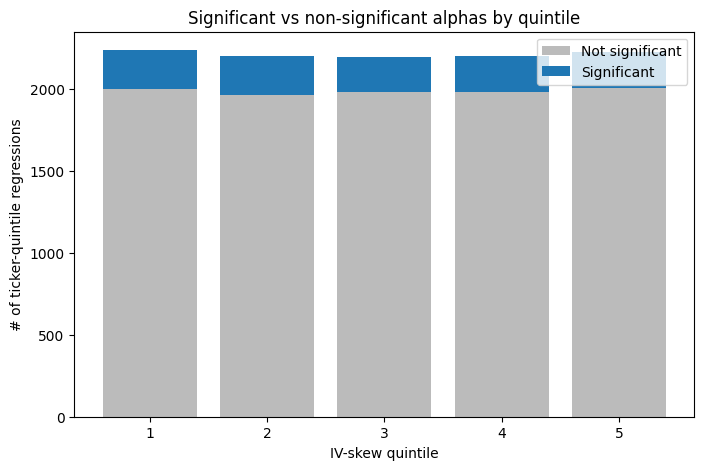

In [32]:
if not panel_results.empty:
    sig_counts = (
        panel_results
        .assign(alpha_sig_flag=panel_results["alpha_sig"].ne(""))
        .groupby("quintile")
        .agg(
            sig_quintiles=("alpha_sig_flag", "sum"),
            non_sig_quintiles=("alpha_sig_flag", lambda x: (~x).sum())
        )
        .reset_index()
        .sort_values("quintile")
    )

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(sig_counts["quintile"], sig_counts["non_sig_quintiles"], label="Not significant", color="#bbbbbb")
    ax.bar(sig_counts["quintile"], sig_counts["sig_quintiles"], bottom=sig_counts["non_sig_quintiles"], label="Significant", color="#1f77b4")
    ax.set_xlabel("IV-skew quintile")
    ax.set_ylabel("# of ticker-quintile regressions")
    ax.set_title("Significant vs non-significant alphas by quintile")
    ax.legend()
    plt.show()


In [33]:
if not panel_results.empty:
    ticker_sig_matrix = (
        panel_results
        .assign(alpha_sig_flag=panel_results["alpha_sig"].ne(""))
        .pivot_table(
            index="ticker",
            columns="quintile",
            values="alpha_sig_flag",
            aggfunc="sum",
            fill_value=0
        )
        .astype(int)
    )
    print("Number of significant alphas per ticker/quintile (counts):")
    display(ticker_sig_matrix.head(15))


Number of significant alphas per ticker/quintile (counts):


quintile,1,2,3,4,5
ticker,,,,,
A,0,0,0,0,0
AA,0,0,0,0,1
AAL,0,0,1,0,0
AAN,0,0,0,0,0
AAOI,0,0,0,0,0
AAON,0,0,0,1,0
AAP,0,0,0,0,1
AAPL,0,1,1,0,0
AAWW,1,0,0,0,0
